In [1]:
from dynamicviz import viz, score

/home/edsun/anaconda3/envs/dynamicviz_installation/lib/python3.8/site-packages/dynamicviz/viz.py:17: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/home/edsun/anaconda3/envs/dynamicviz_installation/lib/python3.8/site-packages/dynamicviz/viz.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import pickle
import seaborn as sns
from scipy.spatial.transform import Rotation

### DynamicViz plotting (rigid alignment + stacked visualization)

In [3]:
with open("results/clustering/dynamicviz_simulated_mix_100_default_params_20rep_bin020_invnorm.pkl", "rb") as f:
    res_dict = pickle.load(f)

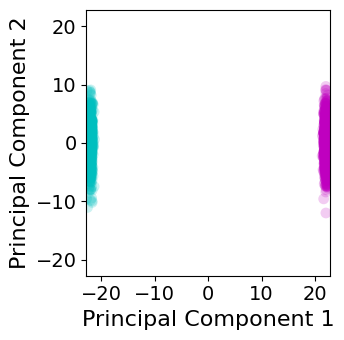

Setting up neighborhoods...
--- 0.0004317760467529297 seconds ---
Populating distances...
--- 3.739229679107666 seconds ---
Computing mean pairwise distance for normalization...
--- 0.30156850814819336 seconds ---
Computing variance scores...
--- 0.5423600673675537 seconds ---


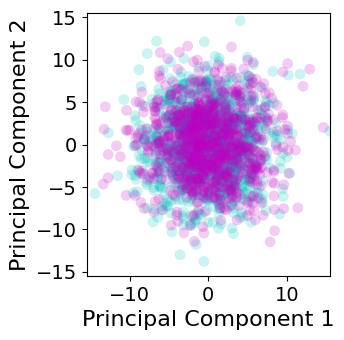

Setting up neighborhoods...
--- 0.0006630420684814453 seconds ---
Populating distances...
--- 3.422008752822876 seconds ---
Computing mean pairwise distance for normalization...
--- 0.1589040756225586 seconds ---
Computing variance scores...
--- 0.7107377052307129 seconds ---


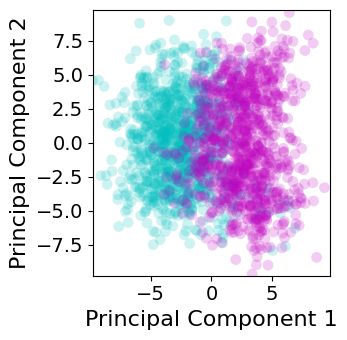

Setting up neighborhoods...
--- 0.0006003379821777344 seconds ---
Populating distances...
--- 3.740222692489624 seconds ---
Computing mean pairwise distance for normalization...
--- 0.2862124443054199 seconds ---
Computing variance scores...
--- 0.439953088760376 seconds ---


In [4]:
ref_idx = 9 #4, 5, 9, 10

vscores = []
labels = []

for key in res_dict.keys():
    
    # Get dataframe from subdict of results
    df = pd.DataFrame.from_dict(res_dict[key])
    
    # Rigid Alignment -- all original indices are in order so no need to map
    
    points0 = df[df["bootstrap_number"]==ref_idx][["x1","x2"]].values
    points0 = np.hstack((points0, np.zeros(points0.shape[0]).reshape(points0.shape[0],1)))
    points0[:,0] = points0[:,0]-np.mean(points0[:,0])
    points0[:,1] = points0[:,1]-np.mean(points0[:,1])
    
    for bnum in np.unique(df["bootstrap_number"]):
        points = df[df["bootstrap_number"]==bnum][["x1","x2"]].values
        points = np.hstack((points, np.zeros(points.shape[0]).reshape(points.shape[0],1)))
        points[:,0] = points[:,0]-np.mean(points[:,0])
        points[:,1] = points[:,1]-np.mean(points[:,1])
        r = Rotation.align_vectors(points0, points)[0]
        rpoints = r.apply(points)
        
        # set new value
        df["x1"][df["bootstrap_number"]==bnum] = rpoints[:,0]
        df["x2"][df["bootstrap_number"]==bnum] = rpoints[:,1]        
        
    df["label"] = df["label"].astype(str)
    
    # Create DynamicViz using stacked modality
    fig = viz.stacked(df, 'label', show=True, colors=["c", "m"], width=3.5, height=3.5, s=60, alpha=0.2,
                      save=f"plots/scpi_clustering/{key}_piwidth_pc_plot_mix100_bin020_DYNAMICVIZ100.pdf",
                      xlabel="Principal Component 1", ylabel="Principal Component 2",
                      rasterized=True, show_legend=False, solid_legend=True)
    
    # Compute global variance score
    vscores.append(score.variance(df, method='global'))
    labels.append(key)

In [11]:
for vscore in vscores:
    print(np.mean(vscore))
    print(np.median(vscore))

0.006224674058230045
0.006180918241903203
0.25818643177833633
0.25229124813595877
0.2277897723974586
0.22346069889642683


In [5]:
labels = [[labels[i]]*len(vscores[i]) for i in range(len(vscores))]

df = pd.DataFrame([])
df["Variance Score"] = np.concatenate(vscores)
df["Approach"] = np.concatenate(labels)

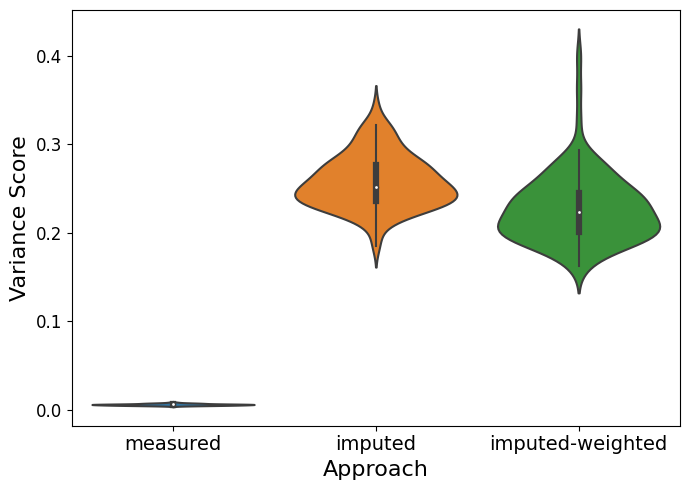

In [10]:
plt.figure(figsize=(7,5))
sns.violinplot(x="Approach", y="Variance Score", data=df, scale='width')
plt.xlabel("Approach", fontsize=16)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/scpi_clustering/dynamicviz_variance_scores_violin.pdf', dpi=300, bbox_inches='tight')
plt.show()